# Manuscript Figures

This notebook contains all necessary functions to reproduce figures in the manuscript. 

## Table of contents
- [Notes and some preparations](#1)
- [Figure 2](#2)
- [Figure 3](#3)

## Notes and some preparations <a name="1"></a>

We do show the functions that generated these log files as well, but they will take some time to run and will likely be slightly different from run to run due to randomness. 

For these reasons, we saved the simulation results as log files, and all analyses are made with these saved log files to ensure exact reproduction of the figures. Log files can be found in the `manuscript figures/saved logs/` folder.

More simulation functions can be found in `chem_simulate.py`, and more analysis functions (e.g., for figures in the SI) can be found in `chem_analyze.py`

In [54]:
# bandit imports 
import algos_regret  # Implemented bandit algorithms (that minimize regret)
from chem_arms import simulate_propose_and_update, simulate_propose_and_update_interpolation
from chem_analyze import get_accuracy_bandit_algos, get_accuracy_random_exploration, plot_accuracy_best_arm
import utils  

# other library imports
import pathlib
import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm
import random
import itertools
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100  # change dpi for higher res display in notebook

In [2]:
log_dir = './manuscript figures/notebook logs/'  # if you simulate from this notebook, logs are saved here

## Figure 2 <a name="2"></a>

### Nickel borylation dataset

Simulate Bayes UCB (beta prior) and Random exploration on the nickel borylation dataset first.

In [ ]:
def nickel_borylation_simulate():
    
    # fetch ground truth data and process
    ground_truth = pd.read_csv(
        'https://raw.githubusercontent.com/beef-broccoli/ochem-data/main/deebo/nib-etoh.csv', index_col=0)

    ground_truth['yield'] = ground_truth['yield'].apply(utils.cutoffer, args=(50,))
    ligands = ground_truth['ligand_name'].unique()
    electrophiles = ground_truth['electrophile_id'].unique()

    #######################################################################################################################
    # changable parameters
    scope_dict = {'electrophile_id': electrophiles,
                  'ligand_name': ligands,}  # entire reaction scope
    arms_dict = {'ligand_name': ligands}  # conditions
    algos = [algos_regret.BayesUCBBetaPPF(len(ligands)),
             algos_regret.Random(len(ligands))
             ]  
    wkdir = f'{log_dir}/nickel-borylation/'
    num_sims = 500  # 500 in paper 
    num_round = 100  # 100 in paper
    num_exp = 1
    propose_mode = 'random'
    #######################################################################################################################
    
    # simulate each algo 
    for algo in algos:
        dir_name = f'{wkdir}{algo.__str__()}-{num_sims}s-{num_round}r-{num_exp}e/'  # change folder name here
        p = pathlib.Path(dir_name)
        p.mkdir(parents=True)

        simulate_propose_and_update(scope_dict, arms_dict, ground_truth, algo,
                                    dir=dir_name, num_sims=num_sims,
                                    num_round=num_round, num_exp=num_exp, propose_mode=propose_mode,
                                    )
    return

nickel_borylation_simulate()

<div class="alert alert-block alert-info"> <b>Note: </b> If you get a `File exists` error, delete the file first. This is by design to prevent accidental overwrite of log files. </div>

Explore-then-commit is separately simulated with a different function. For similar reasons as simulation logs, we ran simulations and saved the results as a .npy file, and that file is used for all analysis. 

In [10]:
def nickel_borylation_simulate_etc(max_sample=4, n_simulations=10000):

    """
    Functions to simulate explore-then-commit baseline

    Parameters
    ----------
    max_sample: int
        maximum number of samples for each condition. Usually (# of budget experiments) % (# of conditions). 
    n_simulations: int
        how many times explore-then-commit is simulated on the same dataset.

    Returns
    -------

    """

    # need to specifiy top conditions to know whether ETC algorithm gets it right or wrong
    top_three = ['Cy-JohnPhos', 'P(p-Anis)3', 'PPh2Cy']

    # fetch ground truth data and apply yield cutoff
    df = pd.read_csv(
        'https://raw.githubusercontent.com/beef-broccoli/ochem-data/main/deebo/nib-etoh.csv', index_col=0)
    df['yield'] = df['yield'].apply(lambda x: 0 if x<50 else 1)
    
    # start simulating ETC 
    percentages = []  # accuracy; or percentage of simulations that ETC got it right
    avg_cumu_rewards = []
    gb = df.groupby(by=['ligand_name'])  # group by condition 
    for n_sample in tqdm(range(max_sample), desc='1st loop'):
        count = 0
        reward = 0
        for i in tqdm(range(n_simulations), desc='2nd loop', leave=False):
            sample = gb.sample(n_sample+1).groupby('ligand_name')  # sample each condition n times, groupby conditions
            sample_mean = sample.mean(numeric_only=True)
            sample_sum = sample.sum(numeric_only=True).sum().values[0]
            reward = reward+sample_sum
            maxs = sample_mean.loc[sample_mean['yield']==sample_mean['yield'].max()]
            random_one = random.choice(list(maxs.index))  # tie breaking when multiple maxes exist
            if random_one in top_three:
                count = count+1
        percentages.append(count/n_simulations)
        avg_cumu_rewards.append(reward/n_simulations)

    return percentages, avg_cumu_rewards

accuracy, _ = nickel_borylation_simulate_etc(4, 100)  # 10000 simulations in paper
accuracy

1st loop:   0%|          | 0/4 [00:00<?, ?it/s]

2nd loop:   0%|          | 0/100 [00:00<?, ?it/s]

2nd loop:   0%|          | 0/100 [00:00<?, ?it/s]

2nd loop:   0%|          | 0/100 [00:00<?, ?it/s]

2nd loop:   0%|          | 0/100 [00:00<?, ?it/s]

[0.28, 0.34, 0.42, 0.48]

The details of how our stepwise ETC baselines are established by round can be found in the SI. We need to add a 0.0% accuracy (since no accuracy will be availble before the first round of experiments are completed), and repeat each accuracy number by the number of possible conditions. 

In [13]:
accuracy = np.append(0.0, accuracy)
accuracy = np.repeat(accuracy, 23)  # 23 ligands in nickel borylation dataset
#np.save(f'{log_dir}/nickel-borylation/nickel_borylation_etc.npy', accuracy)
accuracy

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28,
       0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28,
       0.28, 0.28, 0.28, 0.28, 0.34, 0.34, 0.34, 0.34, 0.34, 0.34, 0.34,
       0.34, 0.34, 0.34, 0.34, 0.34, 0.34, 0.34, 0.34, 0.34, 0.34, 0.34,
       0.34, 0.34, 0.34, 0.34, 0.34, 0.42, 0.42, 0.42, 0.42, 0.42, 0.42,
       0.42, 0.42, 0.42, 0.42, 0.42, 0.42, 0.42, 0.42, 0.42, 0.42, 0.42,
       0.42, 0.42, 0.42, 0.42, 0.42, 0.42, 0.48, 0.48, 0.48, 0.48, 0.48,
       0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.

### Deoxyfluorination and C-N cross-coupling datasets 

Very similar to how nickel borylation are simulated. We only provide the bandit algorithms simulation functions for the two datasets, as the ETC simulation functions are the same as above (just need to change the dataset locations, and condition names)

In [ ]:
def deoxyfluorination_simulate():
    
    ground_truth = pd.read_csv(
        'https://raw.githubusercontent.com/beef-broccoli/ochem-data/main/deebo/deoxyf.csv')

    ground_truth['yield'] = ground_truth['yield'].apply(utils.scaler)
    ground_truth = ground_truth[['base_name',
                                 'fluoride_name',
                                 'substrate_name',
                                 'yield']]
    bases = ground_truth['base_name'].unique()
    fluorides = ground_truth['fluoride_name'].unique()
    substrates = ground_truth['substrate_name'].unique()

    # changable parameters
    scope_dict = {'base_name': bases,
                  'fluoride_name': fluorides,
                  'substrate_name': substrates}
    arms_dict = {'base_name': bases,
                 'fluoride_name': fluorides}
    algos = [algos_regret.BayesUCBGaussian(len(bases)*len(fluorides)), 
             algos_regret.Random(len(ligands))]
    wkdir = f'{log_dir}/deoxyfluorination/'
    num_sims = 500
    num_round = 100
    num_exp = 1
    propose_mode = 'random'

    dir_name = f'{wkdir}{algo.__str__()}-{num_sims}s-{num_round}r-{num_exp}e/'
    p = pathlib.Path(dir_name)
    p.mkdir(parents=True)
    
    for algo in algos:
        simulate_propose_and_update(scope_dict, arms_dict, ground_truth, algo,
                                    dir=dir_name, num_sims=num_sims,
                                    num_round=num_round, num_exp=num_exp, propose_mode=propose_mode)
    return None


def cn_maldi_simulate():

    ground_truth = pd.read_csv(
        'https://raw.githubusercontent.com/beef-broccoli/ochem-data/main/deebo/maldi-bromide.csv')
    eic_max = ground_truth['EIC(+)[M+H] Product Area'].max()
    ground_truth['yield'] = ground_truth['EIC(+)[M+H] Product Area'] / eic_max  # "yield"
    ground_truth = ground_truth[['substrate_id',
                                 'condition',
                                 'yield',]]
    conditions = ground_truth['condition'].unique()
    substrates = ground_truth['substrate_id'].unique()

    # changable parameters
    scope_dict = {'condition': conditions,
                  'substrate_id': substrates}
    arms_dict = {'condition': conditions}
    n_arms = len(conditions)
    algos = [algos_regret.BayesUCBGaussian(n_arms),
             algos_regret.Random(n_arms)]
    wkdir = f'{log_dir}/cn_maldi/bromide/'
    num_sims = 500
    num_round = 100
    num_exp = 1
    propose_mode = 'random'
    
    for algo in algos:
        dir_name = f'{wkdir}{algo.__str__()}-{num_sims}s-{num_round}r-{num_exp}e/'
        p = pathlib.Path(dir_name)
        p.mkdir(parents=True)

        simulate_propose_and_update(scope_dict, arms_dict, ground_truth, algo,
                                    dir=dir_name, num_sims=num_sims,
                                    num_round=num_round, num_exp=num_exp, propose_mode=propose_mode)
    return None

### Plot saved results (reproduce Fig. 2b)

As previously mentioned, we have saved the results from our simulation runs. These log files are directly used for analysis. 

One other thing to note is that we need to supply the indices of the top-n conditions. These can be identified from the `arms.pkl` file generated during simulation. For example:

In [15]:
import pickle 

with open('./manuscript figures/saved logs/nickel_borylation_bayes_ucb_beta/arms.pkl', 'rb') as f:
    arms = pickle.load(f)
    
arms

{0: ('A-paPhos',),
 1: ('CX-FBu',),
 2: ('CX-PCy',),
 3: ('Cy-BippyPhos',),
 4: ('Cy-JohnPhos',),
 5: ('Cy-PhenCar-Phos',),
 6: ('Cy-vBRIDP',),
 7: ('Kwong',),
 8: ('MeO-KITPHOS',),
 9: ('MePhos',),
 10: ('PCy3 HBF4',),
 11: ('Ph-DavePhos',),
 12: ('Ph-SPhos',),
 13: ('Ph-XPhos',),
 14: ('PMe3 HBF4',),
 15: ('P(o-Anis)3',),
 16: ('P(p-Anis)3',),
 17: ('P(p-F-Ph)3',),
 18: ('PPh2Cy',),
 19: ('PPh3',),
 20: ('PPhtBu2',),
 21: ('PXy3',),
 22: ('VPhos',)}

In [36]:
def fig_2b():
    
    dir_path = 'manuscript figures/saved logs/fig2/'
    
    # get_accuracy_bandit_algos calculates the accuracies from simulation logs and provided best_arm_indexes
    # see chem_analyze.py for more details on this function
    nib = get_accuracy_bandit_algos(
        f'{dir_path}/nickel_borylation_bayes_ucb_beta/log.csv', best_arm_indexes=[4, 16, 18])
    deoxyf = get_accuracy_bandit_algos(
        f'{dir_path}/deoxyfluorination_bayes_ucb_gaussian/log.csv', best_arm_indexes=[14, 19])
    maldi = get_accuracy_bandit_algos(
        f'{dir_path}/cn_maldi_bayes_ucb_gaussian/log.csv', best_arm_indexes=[0])
    maldi = np.insert(maldi[1:], [0], [0])  # gets rid of exploration artifact (first experiment is always Cu due to how exploration is implemented)

    nib_etc_baseline = np.load(f'{dir_path}/nickel_borylation_etc.npy')
    deoxyf_etc_baseline = np.load(f'{dir_path}/deoxyfluorination_etc.npy')
    maldi_etc_baseline = np.load(f'{dir_path}/cn_maldi_etc.npy')
    
    # get_accuracy_random_exploration calculates accuracies from random exploration
    # see chem_analyze.py for more details on this function
    nib_random_baseline = get_accuracy_random_exploration(
        f'{dir_path}/nickel_borylation_random/log.csv', best_arm_indexes=[4, 16, 18])
    deoxyf_random_baseline = get_accuracy_random_exploration(
        f'{dir_path}/deoxyfluorination_random/log.csv', best_arm_indexes=[14, 19])
    maldi_random_baseline = get_accuracy_random_exploration(
        f'{dir_path}/cn_maldi_random/log.csv', best_arm_indexes=[0])

    legends = [
        'Nickel borylation, \n top-3 accuracy, \n Bayes UCB (beta prior)',
        'Deoxyfluorination, \n top-2 accuracy, \n Bayes UCB (gaussian prior)',
        'C-N cross-coupling, \n top-1 accuracy, \n Bayes UCB (gaussian prior)'
    ]

    plt.rcParams['savefig.dpi'] = 300

    plt.plot(nib[:100], label=legends[0], color='#1f77b4', alpha=1, lw=2)
    plt.plot(nib_etc_baseline[:100], color='#1f77b4', ls='--', alpha=1, lw=2)
    plt.plot(nib_random_baseline[:100], color='#1f77b4', ls=(0, (3, 1, 1, 1, 1, 1)), alpha=1, lw=2)

    plt.plot(deoxyf[:100], label=legends[1], color='#ff7f0e', alpha=1, lw=2)
    plt.plot(deoxyf_etc_baseline[:100], color='#ff7f0e', ls='--', alpha=1, lw=2)
    plt.plot(deoxyf_random_baseline[:100], color='#ff7f0e', ls=(0, (3, 1, 1, 1, 1, 1)), alpha=1, lw=2)

    plt.plot(maldi[:100], label=legends[2], color='#2ca02c', alpha=1, lw=2)
    plt.plot(maldi_etc_baseline[:100], color='#2ca02c', ls='--', alpha=1, lw=2)
    plt.plot(maldi_random_baseline[:100], color='#2ca02c', ls=(0, (3, 1, 1, 1, 1, 1)), alpha=1, lw=2)

    plt.plot([], label='Baseline \n Explore-then-commit', ls='--', color='k')
    plt.plot([], label='Baseline \n Pure exploration', ls=(0, (3, 1, 1, 1, 1, 1)), color='k')

    plt.grid(visible=True, which='both', alpha=0.5)
    plt.legend(bbox_to_anchor=(1.2, 1), loc="upper left", labelspacing=1, ncols=2, columnspacing=3)
    plt.xlabel('Number of experiments')
    plt.ylabel('Top-n accuracy')
    plt.title('Accuracy of identifying top general conditions for 3 datasets')
    plt.tight_layout()
    plt.show()
    return

/var/folders/j8/j9vdlwx52872vvl9_7r57zfm0000gn/T/ipykernel_68411/171344954.py:56: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


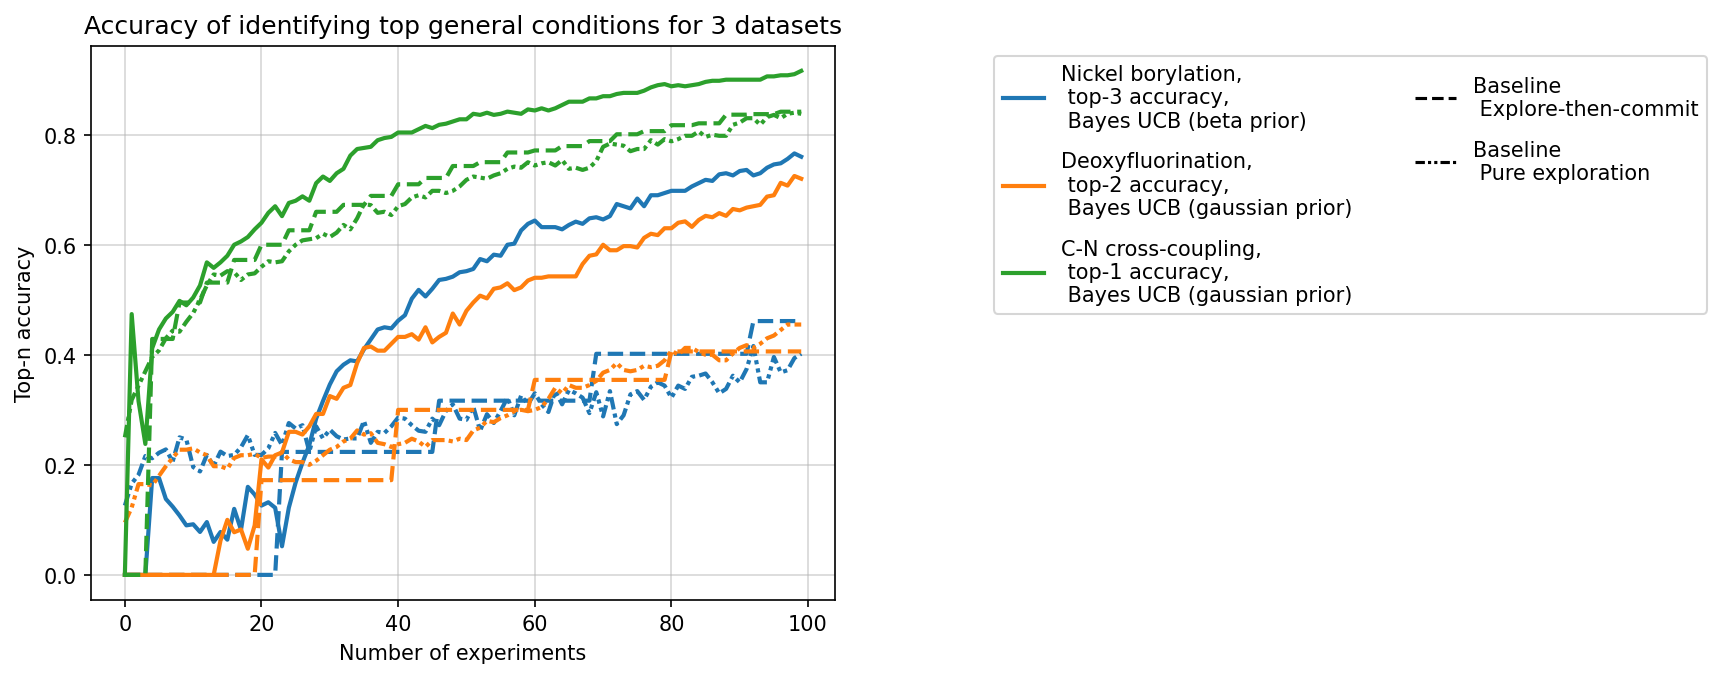

In [48]:
fig_2b()  # takes a few seconds; we usually save the calculated accuracies instead of 'get_accuracy_' every time 

## Fig 3 <a name="3"></a>

### Fig. 3a heatmap 

In [32]:
def fig_3a():
    df = pd.read_csv('https://raw.githubusercontent.com/beef-broccoli/ochem-data/main/deebo/cn-processed.csv')
    df = df[['base_name', 'ligand_name', 'substrate_id', 'additive_id', 'yield']]

    LS = df['ligand_name'].unique()
    BS = df['base_name'].unique()
    
    # calculate average by condition
    ds = []
    averages = []
    for l, b in itertools.product(LS, BS):
        tempdf = df.loc[(df['ligand_name'] == l) & (df['base_name'] == b)]
        tempdf = tempdf.drop(['ligand_name', 'base_name'], axis=1)
        a = np.array(tempdf.groupby(['substrate_id'], sort=True)['yield'].apply(list).to_list())
        # each row of a is a substrate, each column of a is an additive
        ds.append(a)
        averages.append(round(np.average(a), 2))

    data = np.vstack([np.hstack(ds[0:3]),
                      np.hstack(ds[3:6]),
                      np.hstack(ds[6:9]),
                      np.hstack(ds[9:12])])  # could've written some clever loop here, but this is way easier

    fig, ax = plt.subplots()
    im = ax.imshow(data, cmap='inferno')
    text_kwargs = dict(ha='center', va='center', fontsize=15, color='white')
    ii = 0
    for i in range(4):
        for j in range(3):
            ax.add_patch(Rectangle((20 * j - 0.5, 15 * i - 0.5), 20, 15, fill=False, edgecolor='white', lw=2))
            plt.text(20 * j + 9.5, 15 * i + 7, averages[ii], **text_kwargs)
            ii = ii + 1

    #plt.axis('off')
    ax.set_xticks([9.5, 29.5, 49.5], BS, fontsize=14)
    ax.set_yticks([7, 22, 37, 52], LS, fontsize=14)
    ax.set_xlabel('Bases', fontsize=15)
    ax.set_ylabel('Ligands', fontsize=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    cbar = plt.colorbar(im)
    cbar.ax.tick_params(labelsize=13)
    cbar.ax.set_ylabel('Yield (%)', rotation=270, fontsize=14, labelpad=25)
    plt.rcParams['savefig.dpi'] = 300

    plt.show()

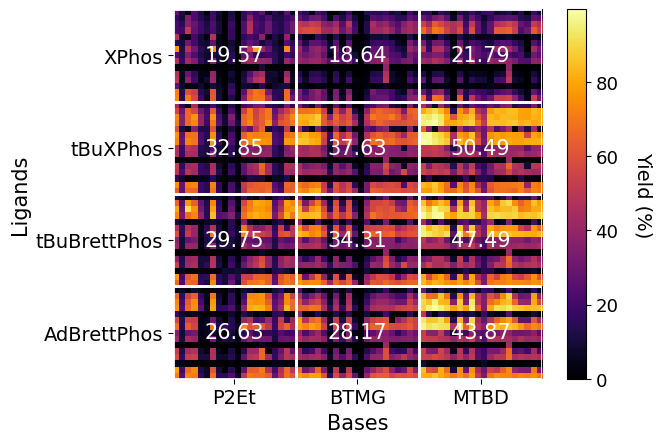

In [55]:
fig_3a()

### Simulate C-N cross-coupling dataset with bandit algorithms (for 3c)

Simulate different bandit algorithms with dataset. 

In [30]:
def cn_simulate():
    # fetch ground truth data
    ground_truth = pd.read_csv(
        'https://raw.githubusercontent.com/beef-broccoli/ochem-data/main/deebo/cn-processed.csv')

    ground_truth['yield'] = ground_truth['yield'].apply(utils.scaler)
    ground_truth = ground_truth[['base_name',
                                 'ligand_name',
                                 'substrate_id',
                                 'additive_id',
                                 'yield']]

    bases = ground_truth['base_name'].unique()
    ligands = ground_truth['ligand_name'].unique()
    additives = ground_truth['additive_id'].unique()
    substrates = ground_truth['substrate_id'].unique()

    scope_dict = {'base_name': bases,
                  'ligand_name': ligands,
                  'additive_id': additives,
                  'substrate_id': substrates}
    arms_dict = {'base_name': bases,
                 'ligand_name': ligands}
    n_arms = len(bases)*len(ligands)
    algos = [algos_regret.UCB1Tuned(n_arms),
             algos_regret.AnnealingEpsilonGreedy(n_arms),
             algos_regret.ThompsonSamplingGaussianFixedVar(n_arms, assumed_sd=0.25),
             algos_regret.ThompsonSamplingGaussianFixedVarSquared(n_arms),
             algos_regret.BayesUCBGaussian(n_arms, assumed_sd=0.25, c=2),
             algos_regret.BayesUCBGaussianSquared(n_arms, c=2),]
    wkdir = f'{log_dir}/cn/'
    num_sims = 500
    num_round = 100
    num_exp = 1
    propose_mode = 'random'
    
    for algo in algos:
        dir_name = f'{wkdir}{algo.__str__()}-{num_sims}s-{num_round}r-{num_exp}e/'
        p = pathlib.Path(dir_name)
        p.mkdir(parents=True)

        simulate_propose_and_update(scope_dict, arms_dict, ground_truth, algo,
                                    dir=dir_name, num_sims=num_sims,
                                    num_round=num_round, num_exp=num_exp, propose_mode=propose_mode)
cn_simulate()

simulations:   0%|          | 0/3 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

simulations:   0%|          | 0/3 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

simulations:   0%|          | 0/3 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

simulations:   0%|          | 0/3 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

simulations:   0%|          | 0/3 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

simulations:   0%|          | 0/3 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

### Fig. 3c

Again, we are plotting with pre-saved results to exactly reproduce the figures in the paper. Explore-then-commit baseline is also directly loaded from a saved copy, which was generated in the same way as what's shown in the previous section with the nickel borylation reaction.  

In [42]:
def fig_3c(top=3):
    
    """top changes the which top-n accuracy (n=1, 2 or 3)
    """
    
    dd = 'manuscript figures/saved logs/fig3/'
    num_sims = 500  # simulation parameters, used to differentiate results w same algorithm but diff params
    num_round = 100  # by default, this is how directories are named during simulation
    num_exp = 1   # the Fig. 2 example was sanitized, with directories renamed for clarity w diff datasets
    fn_list = [f'{dd}{n}/log.csv' for n in
               [f'ts_gaussian_squared-{num_sims}s-{num_round}r-{num_exp}e',
                f'ts_gaussian_assumed_sd_0.25-{num_sims}s-{num_round}r-{num_exp}e',
                f'ucb1tuned-{num_sims}s-{num_round}r-{num_exp}e',
                f'bayes_ucb_gaussian_squared_c=2-{num_sims}s-{num_round}r-{num_exp}e',
                f'bayes_ucb_gaussian_c=2_assumed_sd=0.25-{num_sims}s-100r-{num_exp}e',
                f'eps_greedy_annealing-{num_sims}s-{num_round}r-{num_exp}e',
                ]]
    
    # Readable legend names for each algorithm
    legend_list = ['TS (implementation 1)',
                   'TS (implementation 2)',
                   'UCB1-Tuned',
                   'Bayes UCB (implementation 1)',
                   'Bayes UCB (implementation 2)',
                   'Annealing ε-greedy',]
    
    # We can make a reverse dictionary {condition_name: condition index}
    #  to directly look up arm index with names
    fp = 'https://raw.githubusercontent.com/beef-broccoli/ochem-data/main/deebo/cn-processed.csv'
    with open(f'{dd}ucb1tuned-{num_sims}s-{num_round}r-{num_exp}e/arms.pkl', 'rb') as f:
        arms_dict = pickle.load(f)

    reverse_arms_dict = {v: k for k, v in arms_dict.items()}
    if top == 3:
        conditions = [('MTBD', 'tBuXPhos'),
                      ('MTBD', 'tBuBrettPhos'),
                      ('MTBD', 'AdBrettPhos')]
    elif top == 2:
        conditions = [('MTBD', 'tBuXPhos'),
                      ('MTBD', 'tBuBrettPhos')]
    elif top == 1:
        conditions = [('MTBD', 'tBuXPhos'),]
    else:
        exit()
    indexes = [reverse_arms_dict[l] for l in conditions]
    
    # Unlike the Fig. 2 example, we do not have to extract the accuracies first
    # Because we are plotting results with the same datasets, there is a function that can directly 
    #  calculate from log.csv and plot all results. 
    # See chem_analyze.plot_accuracy_best_arm for parameter details
    plot_accuracy_best_arm(best_arm_indexes=indexes,
                           fn_list=fn_list,
                           legend_list=legend_list,
                           etc_baseline=True,
                           etc_fp=f'{dd}/etc/top{top}.npy',
                           shade_first_rounds=12,
                           title=f'',
                           xlabel='Number of experiments (time horizon)',
                           legend_title='Algorithm',
                           max_horizon_plot=96,
                           vlines=[36, 72],
                           ylabel=f'Accuracy of identifying top-{top} conditions')
    return None

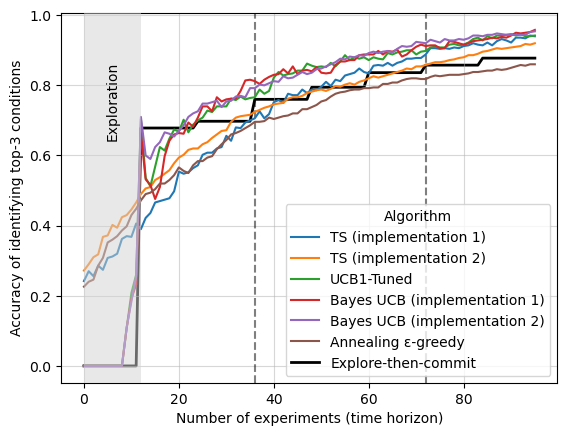

In [56]:
fig_3c()

### Fig. 3d

